# General settings and loading of files

In [88]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

%matplotlib inline

pd.options.display.max_columns = 40  # Affy csv has 30 fields
pd.options.display.mpl_style = 'default'

mpl.rc('figure', figsize=(13, 7))
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [89]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [90]:
GALANTER_CSV = '~/tesina/galanter_SNPs.csv'

LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!

# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

CHR_LENGTHS = '~/tesina/chr_len.csv'

In [91]:
%run discriminate_present_vs_missing.py

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [92]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


In [93]:
%run chromosome_lenghts.py

chr_lengths = read_chr_lengths(CHR_LENGTHS)
max_len = chr_lengths.total_length.max()

### Distancias entre los AIMs por cromosoma

In [94]:
chr_lengths.loc[3]

total_length    198295559
Name: 3, dtype: int64

In [95]:
galanter[galanter.chr == 3][galanter.position > chr_lengths.loc[3].total_length]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs13327370,3,199228595,G,A,0.011,0.23,0.922,AFR,0.606,0.365


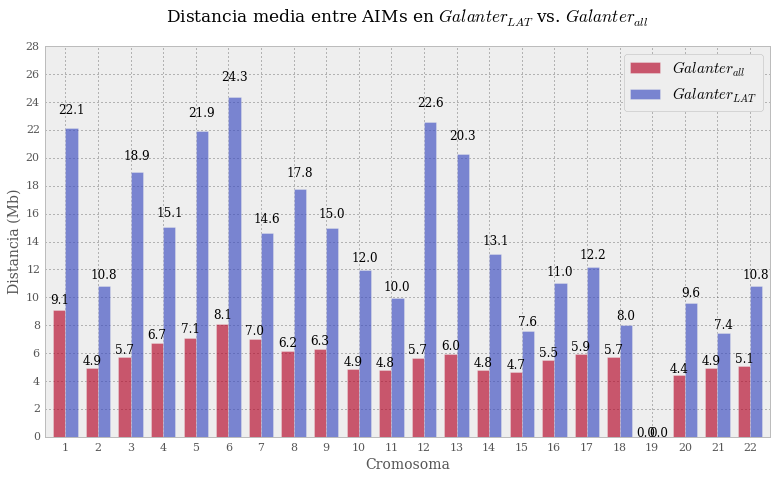

In [96]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

galanter_vs_present_mean_distance_plot(galanter, present)
plt.show()

#### Discusión

* Las distancias medias son mucho mayores en $Galanter_{LAT}$ que en $Galanter_{all}$. En casos extremos, llega a más de 20 Mpb promedio entre AIMs, cuando esas distancias promedio no superan los 8 Mpb en el panel original.

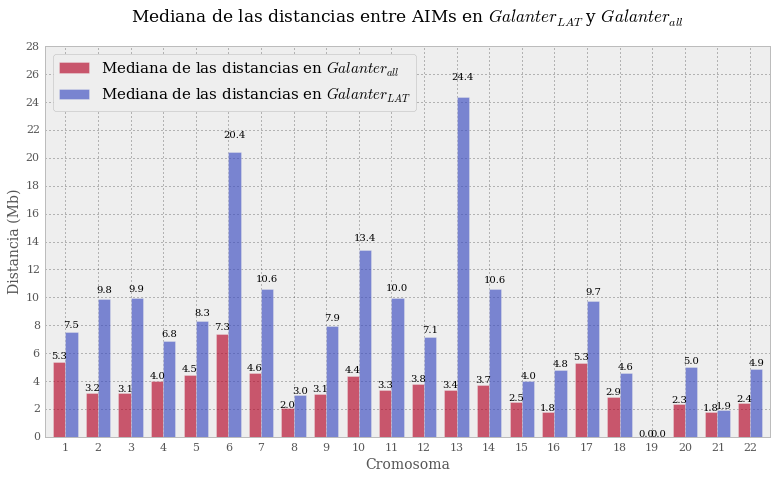

In [97]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

galanter_vs_present_median_distance_plot(galanter, present)
plt.show()

### Discusión

__Nota__: hay un solo AIM en Galanter para el cromosoma 19, de modo que no se grafican distancias.

* En algunos casos extremos, hay hasta 1.4 Mpb (cromosoma 1) y 1 Mpb (cromosoma 8) de distancia entre dos AIMs contiguos.

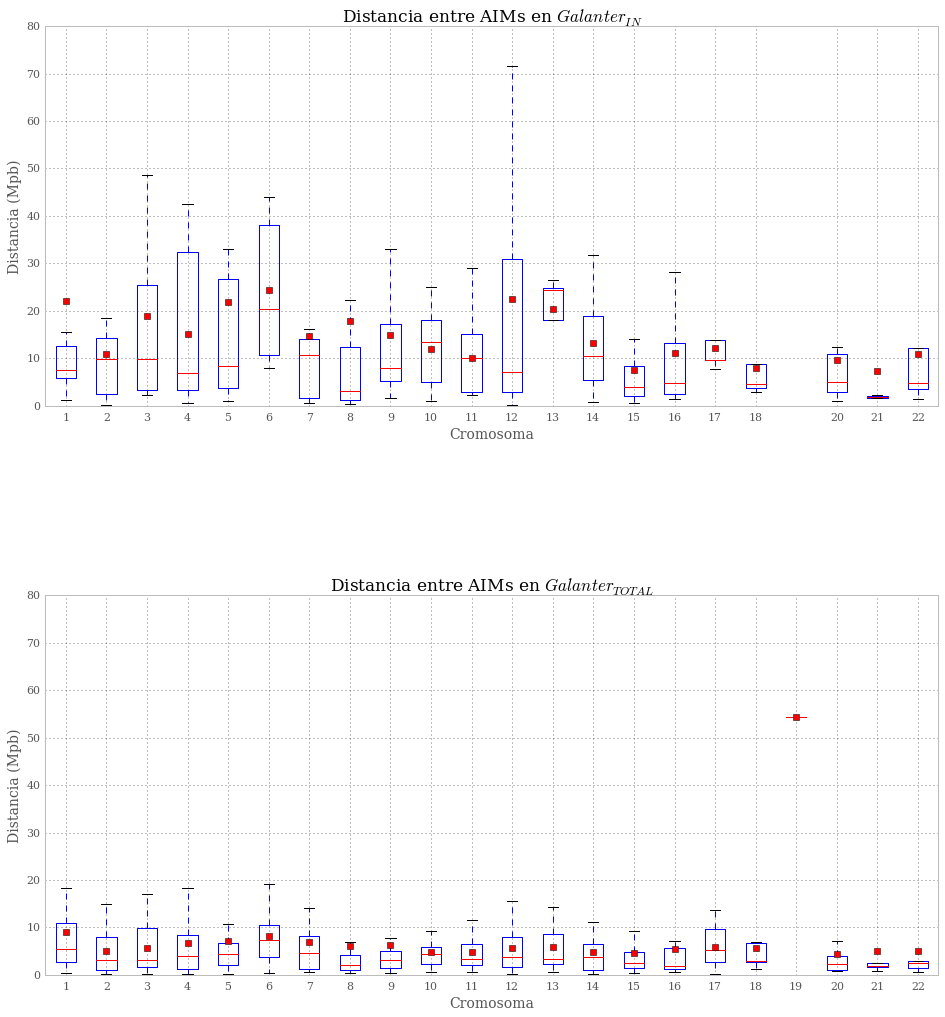

In [98]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(present, ax=ax1, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{IN}$")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(galanter, ax=ax2, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{TOTAL}$")

f = ax2.figure
f.set_figheight(17)
f.set_figwidth(16)

plt.show()

**NOTA**: Con los outliers (`showfliers=True`) la diferencia se agranda aún más.

In [99]:
% run data_munging/distances_between_AIMs.py
% run stats_tests.py

df = snp_distances(galanter, present)
t_test(df['mean_distance_galanter'], df['mean_distance_present'])

('t-critico = -7.20373', 'p-value = 0.00000')

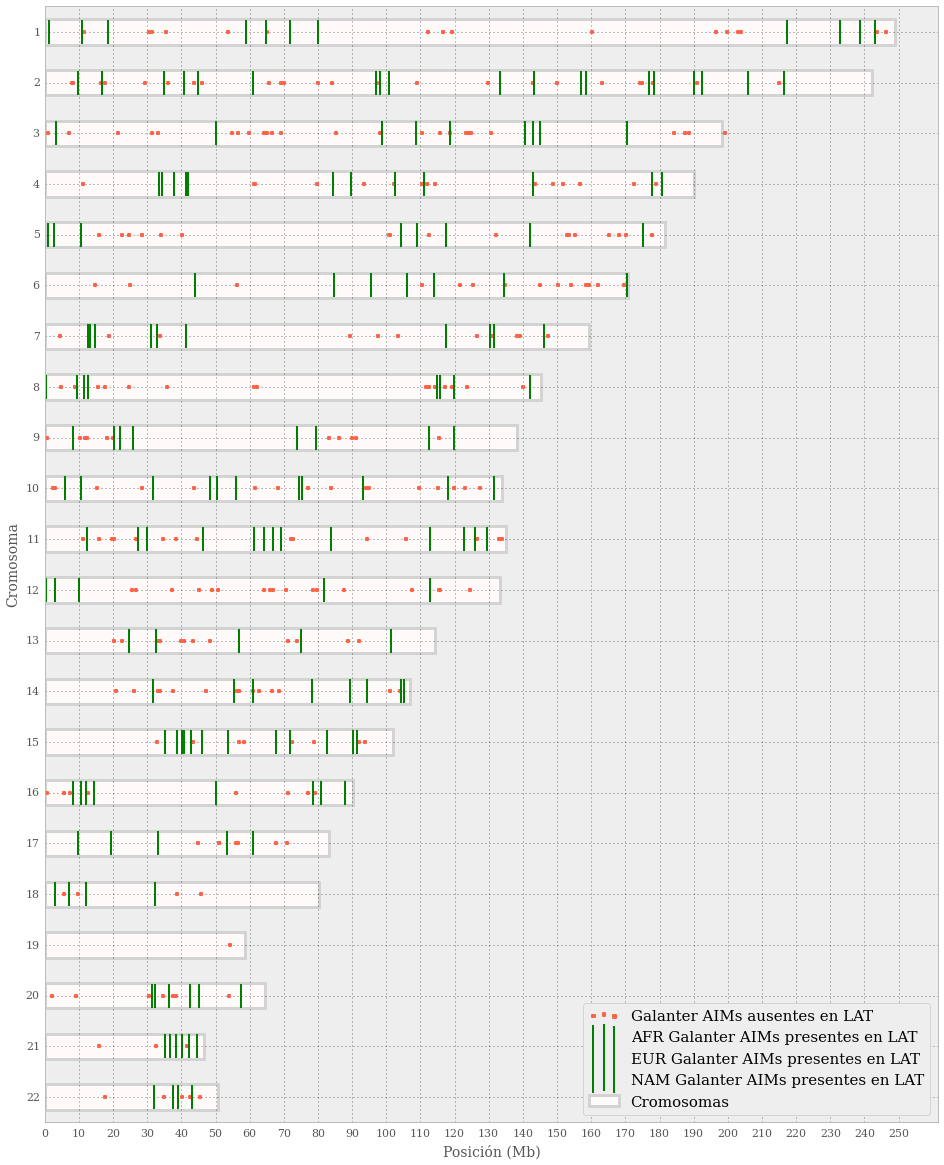

In [100]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
    ('Galanter AIMs ausentes en LAT',
     {'df': missing, 'marker': 's', 's': 7, 'color': 'tomato'}),
        
    ('AFR Galanter AIMs presentes en LAT',
     {'df': present[present.population == "AFR"], 'color': 'g'}),
        
    ('EUR Galanter AIMs presentes en LAT',
     {'df': present[present.population == "EUR"], 'color': 'g'}),
        
    ('NAM Galanter AIMs presentes en LAT',
     {'df': present[present.population == "NAM"], 'color': 'g'}),
])

chromosomes_with_SNPs_plot(chr_lengths, plot_data)
plt.show()

**TODO**: Visualize with special software, tipo http://visualization.ritchielab.psu.edu/phenograms/examples

## Diferenciar por población de referencia, present vs galanter

     $Galanter_{IN}$  $Galanter_{TOTAL}$
AFR         0.344444            0.257848
EUR         0.394444            0.452915
NAM         0.261111            0.289238
     $Galanter_{IN}$  $Galanter_{OUT}$
AFR               53                62
EUR              131                71
NAM               82                47


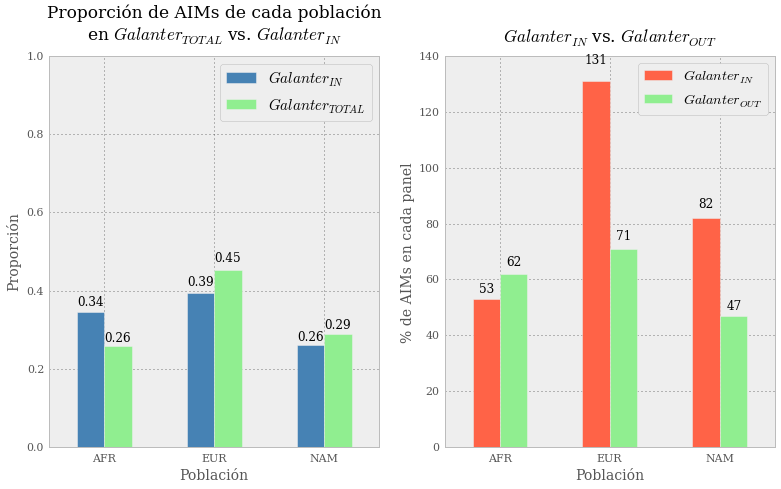

In [101]:
% run superpopulation_ratios_plot.py

superpopulation_ratios_plot(galanter, present)
superpopulation_count_plot(present, missing)

plt.show()

### Discusión

* Los AIMs de Galaner presentes en LAT-1 tienen proporciones poblacionales diferentes a las proporciones del total del panel. En $Galanter_{IN}$
    - la proporción de AFR es .08 mayor
    - la proporción de EUR es .06 menor
    - la proporción de NAM es .03 menor
* Problema: El hecho de que nos quedemos con más AFR en proporción y menos EUR afectará la predición?

# Comparar Galanter con la data de 1000Genomes

In [102]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [103]:
% run extract_SNPs_from_vcf_chromosomes.py

commands = extract_SNPs_from_vcf(galanter.index.values)

# One time only run, to extract the SNPs out of the big chromosome files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

In [104]:
# !rm dumpfiles/galanter_at_1000genomes.csv
# !rm dumpfiles/galanter_snps_frequencies_in_1000genomes.csv

In [105]:
%run read_1000genomes_data.py
%run read_samples_data.py

samples_file = "/home/juan/tesina/1000genomes/integrated_call_samples_v3.20130502.ALL.panel"
samples = read_samples_data(samples_file)

dumpfile = "dumpfiles/galanter_at_1000genomes.csv"
df_1000genomes = get_or_create_1000genomes_df(dumpfile)

dumpfile = "dumpfiles/galanter_snps_frequencies_in_1000genomes.csv"
frequencies_1000g = get_or_create_1000g_frequencies_df(dumpfile, df_1000genomes, samples)

Ejemplo de la data de subpoblaciones que busco, para rs2585897:

http://browser.1000genomes.org/Homo_sapiens/Variation/Population?db=core;r=13:21398479-21399479;v=rs2585897;vdb=variation;vf=2188197

### Comparar SNPs

In [106]:
print("1000 Genomas: ", len(df_1000genomes))
print("Galanter panel: ", len(galanter))

1000 Genomas:  442
Galanter panel:  446


**NOTA** sobre los 4 SNPs que faltan
- un SNP tiene mal el cromosoma en Galanter
- en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [107]:
missing_in_1000g = set(galanter.index) - set(df_1000genomes.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207


### Ver qué subpoblaciones se van en $Galanter_{missing}$ y cuáles quedan

In [108]:
%run population_names.py

dumpfile = "dumpfiles/population_names.csv"
population_names = create_population_names_df(dumpfile)

In [109]:
def whois(pop_code):
    return population_names.loc[pop_code]['Population Description']

In [110]:
whois('ACB')

'African Caribbeans in Barbados'

In [143]:
present.join(frequencies_1000g)[list(populations_to_plot)]

,CHS,STU,BEB,AFR,ITU,IBS,LWK,CDX,CLM,ESN,ASW,EUR,GWD,AMR,PJL,MSL,TSI,GBR,JPT,ACB,GIH,CEU,SAS,YRI,EAS,PEL,FIN,KHV,MXL,CHB,PUR
SNP rsID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rs6685064,0.38,0.53,0.61,0.60,0.65,0.94,0.40,0.27,0.64,0.41,0.43,0.07,0.38,0.38,0.70,0.33,0.96,0.92,0.32,0.46,0.58,0.93,0.39,0.40,0.65,0.44,0.90,0.36,0.56,0.43,0.76
rs12085319,0.50,0.57,0.57,0.95,0.68,0.81,0.02,0.47,0.60,0.03,0.18,0.19,0.05,0.46,0.65,0.02,0.79,0.87,0.58,0.11,0.64,0.81,0.38,0.00,0.46,0.47,0.77,0.61,0.51,0.56,0.57
rs4920310,0.58,0.38,0.31,0.15,0.39,0.16,0.83,0.59,0.41,0.93,0.69,0.87,0.87,0.54,0.24,0.86,0.17,0.12,0.48,0.83,0.34,0.10,0.67,0.88,0.44,0.64,0.11,0.50,0.45,0.66,0.37
rs2984915,0.20,0.28,0.24,0.27,0.26,0.08,0.84,0.24,0.15,0.75,0.57,0.92,0.62,0.85,0.20,0.80,0.12,0.08,0.07,0.67,0.27,0.04,0.75,0.82,0.84,0.05,0.06,0.15,0.06,0.14,0.27
rs6681578,0.27,0.31,0.31,0.09,0.31,0.30,0.91,0.30,0.21,0.95,0.72,0.74,0.93,0.79,0.35,0.95,0.27,0.25,0.16,0.87,0.35,0.21,0.67,0.95,0.72,0.15,0.24,0.33,0.16,0.33,0.29
rs12727814,0.70,0.47,0.45,0.09,0.48,0.23,0.91,0.66,0.47,0.94,0.83,0.73,0.91,0.41,0.44,0.91,0.27,0.25,0.77,0.84,0.40,0.24,0.55,0.95,0.30,0.82,0.35,0.70,0.66,0.67,0.47
rs12022561,0.42,0.81,0.84,0.09,0.76,0.90,0.93,0.48,0.61,0.93,0.86,0.17,0.93,0.45,0.79,0.85,0.86,0.84,0.40,0.93,0.77,0.82,0.21,0.92,0.55,0.24,0.72,0.56,0.49,0.40,0.78
rs10779334,0.04,0.19,0.14,0.16,0.16,0.12,0.89,0.06,0.15,0.87,0.67,0.91,0.89,0.88,0.17,0.83,0.11,0.07,0.12,0.81,0.16,0.10,0.84,0.85,0.92,0.04,0.05,0.09,0.07,0.05,0.19
rs12142968,0.39,0.42,0.37,0.12,0.44,0.78,0.91,0.39,0.54,0.95,0.87,0.26,0.88,0.55,0.43,0.86,0.69,0.77,0.40,0.83,0.38,0.77,0.59,0.88,0.61,0.16,0.68,0.33,0.44,0.42,0.62


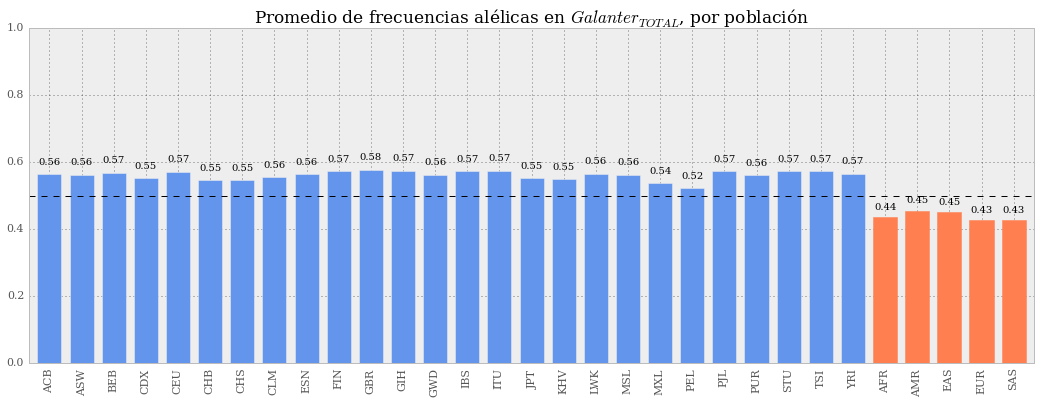

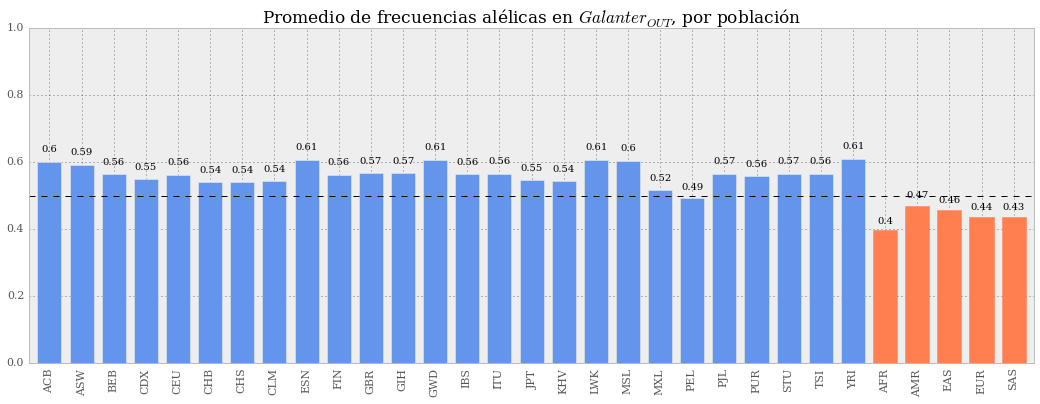

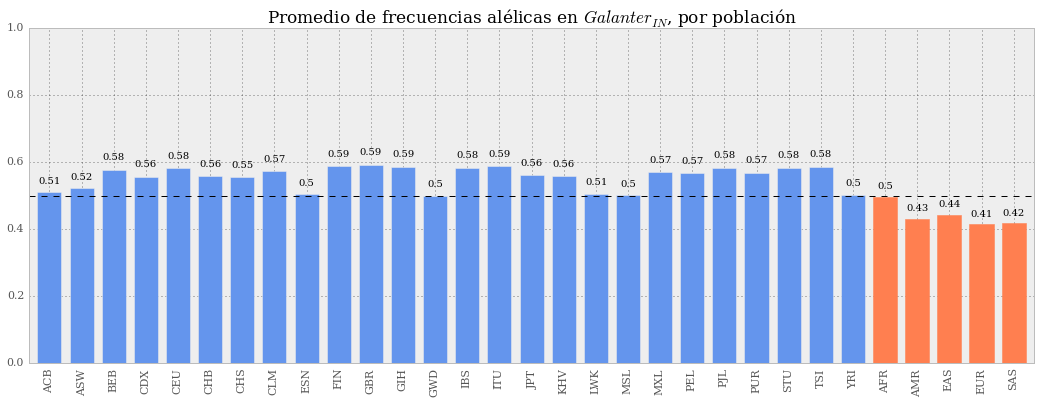

In [139]:
% run analyze_populations_in_galanter.py

populations_to_plot = set(samples.population.unique()) | \
                      set(samples.super_population.unique())
    
dfs = {'$Galanter_{OUT}$': missing,
       '$Galanter_{IN}$': present,
       '$Galanter_{TOTAL}$': galanter}

for name, df in dfs.items():
    ax = plot_mean_freqs(
        df.join(frequencies_1000g), populations_to_plot,
        title="Promedio de frecuencias alélicas en {}, por población".format(name),
    )

    [bar.set_color('coral') for bar in ax.patches[-5:]]
    plt.show()

#### Discusión

**NOTA**: Los promedios de las superpoblaciones AFR, AMR, EUR, según 1000 Genomas para estos SNPs no coinciden con los mismos promedios de las frecuencias que figuran en Galanter.

* El panel completo $Galanter_{TOTAL}$ está balanceado en cuanto a frecuencias alélicas por población: la mayoría se ubica en un promedio de alrededor de 0.57, para cada subpoblación, con un desvío muy bajo: 0.013.
* Ninguna subpoblación parece haber sido afectada en particular por la subselección de SNPs en $Galanter_{IN}$. Todas las frecuencias alélicas se mantienen entre 0.5 y 0.6, rango que incluye también a todas las frecuencias por subpoblación del panel original.

* **DUDA**: no entiendo por qué si todas las frecuencias de subpoblaciones son ~.56, las frecuencias continentales son más bajas, ~.45

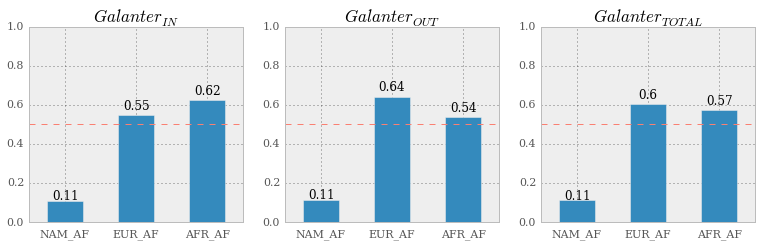

In [113]:
fig, axes = plt.subplots(1, 3, sharey=False)
titles = ("$Galanter_{IN}$", "$Galanter_{OUT}$", "$Galanter_{TOTAL}$" )

for i, df in enumerate([present, missing, galanter]):
    ax = axes[i]
    ax = df.filter(regex='AF').mean().plot(kind='bar', ax=ax, rot=0)
    ax.set_title(titles[i])
    annotate_bars(ax, decimals=2)
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='salmon', linestyle='--')

fig.set_figheight(3.5)
plt.show()

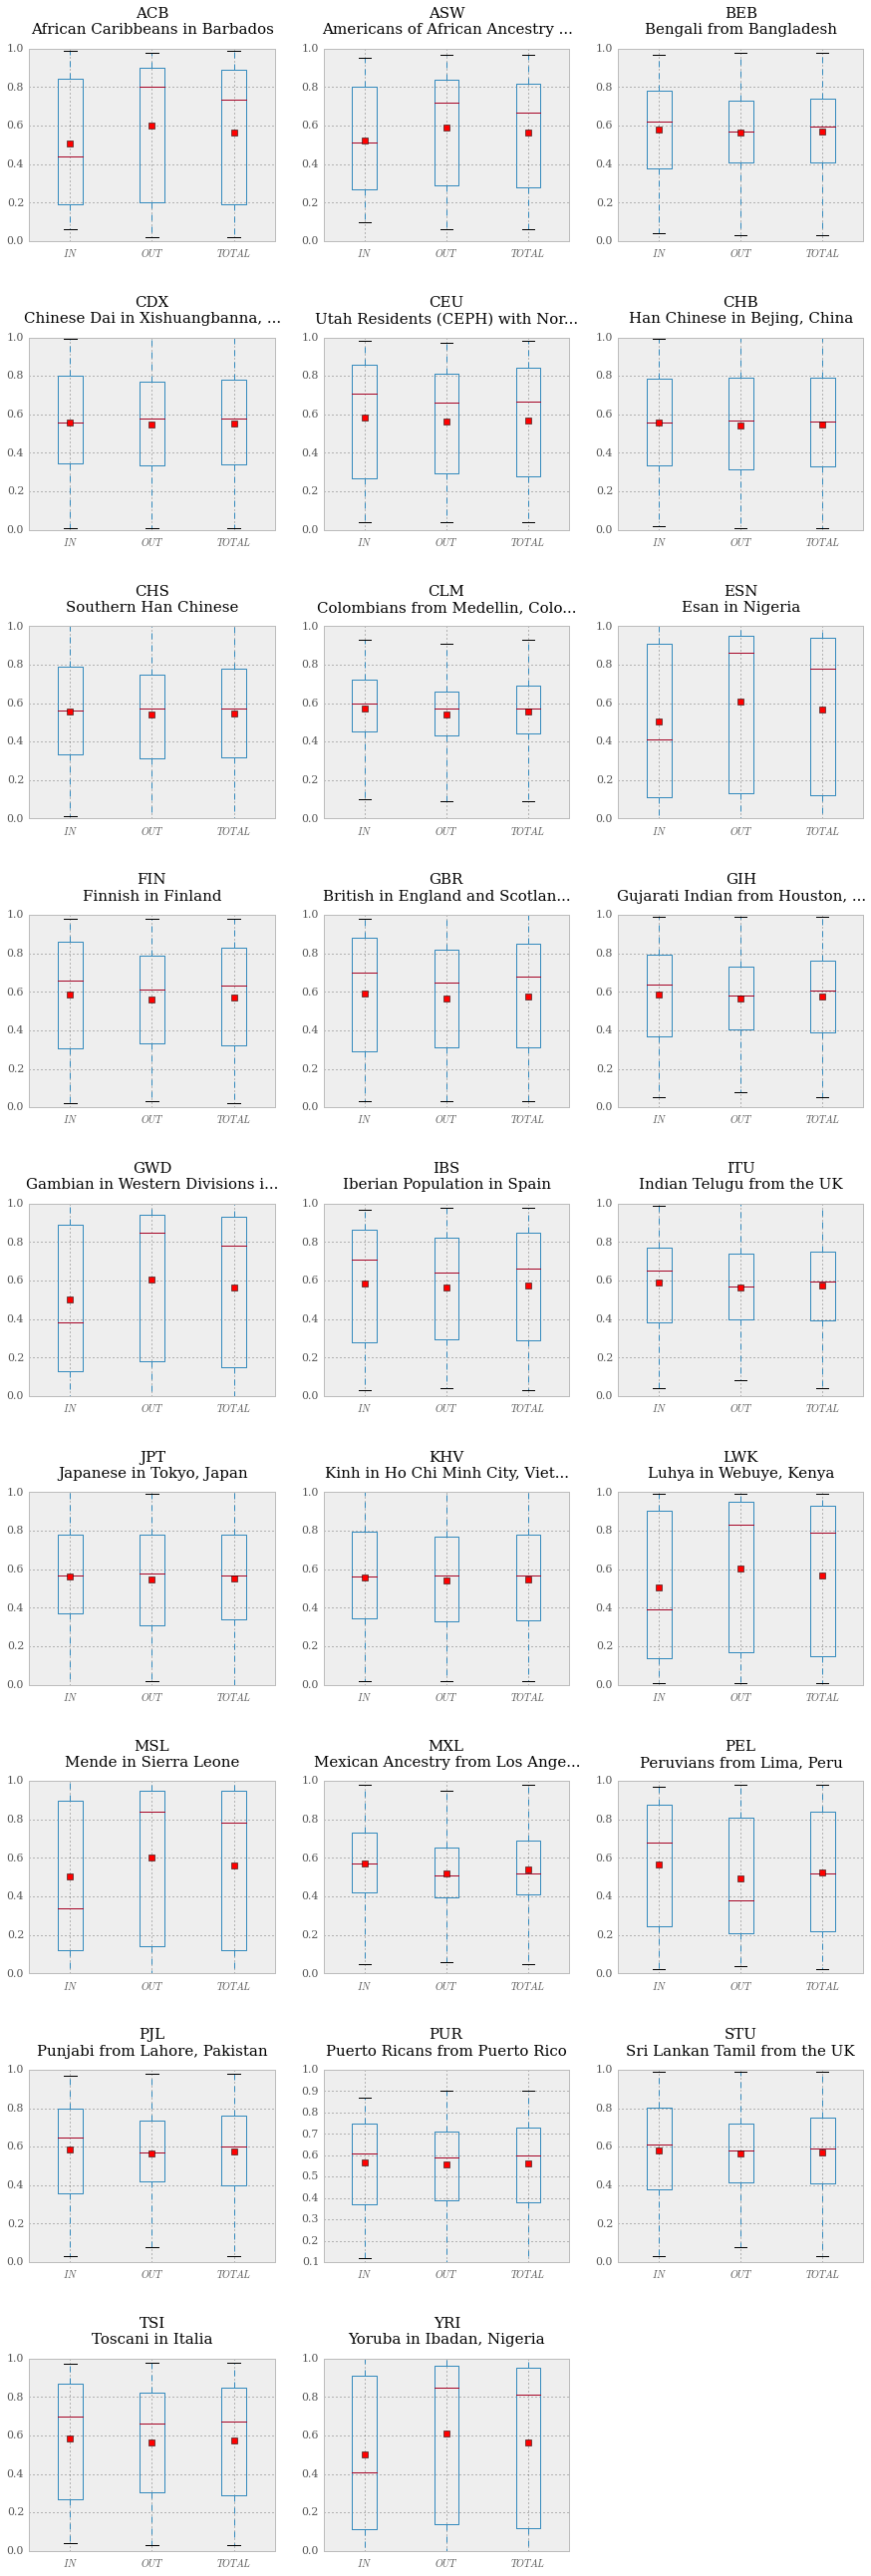

In [291]:
% run helpers/text_helpers.py

populations_to_plot = set(samples.population.unique()) | \
                      set(samples.super_population.unique())
    
get_freqs = lambda df: df.join(frequencies_1000g)[list(populations_to_plot)]

fig = plt.figure(figsize=(15, 45))

for i, population in enumerate(frequencies_1000g.columns[:-6]):  # Quitar el -9
    ax = plt.subplot(9, 3, i+1)
    pop_description = population_names.loc[population]['Population Description']
    ax.set_title(population + "\n" + trunc_text(pop_description, 30), y=1.05, fontsize=15)
    
    pd.DataFrame({
        '$TOTAL$': get_freqs(galanter)[population],
        '$IN$': get_freqs(present)[population],
        '$OUT$': get_freqs(missing)[population],
    }).boxplot(ax=ax, showmeans=True, return_type='both')

plt.show()

#### t test para comparar las dos series

In [114]:
mean_frequencies = lambda df: frequencies_1000g.loc[df.index].mean()

In [115]:
% run stats_tests.py

m("$Galanter_{IN}$")
m(n_test(mean_frequencies(present)))
print()
m("$Galanter_{TOTAL}$")
m(n_test(mean_frequencies(galanter)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

>the farther away the observed or measured sample mean is from the hypothesized mean, the lower the probability (i.e., the p-value) that the null hypothesis is true.

* (?) $Galanter_{total}$ tiene un p-value bajo (0.003), de modo que la $H_0$ no parece verdadera. Es decir, $Galanter_{total}$ no estaría normalmente distribuido.
* (?) $Galanter_{missing}$, por otro lado, tiene un p-value más alto (0.08), pero no tanto, de modo que al menos con una confianza del 90% podemos decir que no está normalmente distribuido. (Está bien esto?)
* Lo que no entiendo del todo es qué implicaría que sí (o que no) esté normalmente distribuido para el panel de Galanter. La selección de SNPs no es azarosa, por qué habríamos de esperar eso?

<IPython.core.display.Math object>

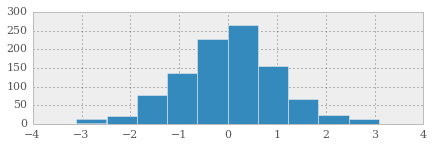

In [116]:
# Para una distribución normal, el p-value es alto!

% run stats_tests.py

s = np.random.normal(0, 1, 1000)
m(n_test(s))
pd.Series(s).hist(figsize=(7, 2))
plt.show()

In [117]:
% run stats_tests.py

# t-test assumes equal variances between the two sets?
# se asumen distribuciones normales??

for txt in t_test(mean_frequencies(galanter), mean_frequencies(present)):
    m(txt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$p > t$

Si la $H_0$ es que ambas medias son estadíticamente iguales, entonces se confirmó?

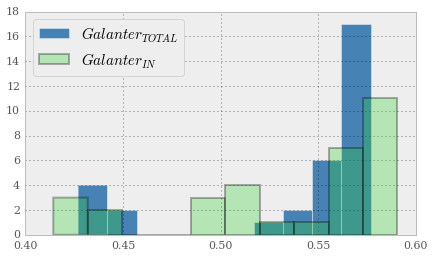

In [118]:
ax = plt.subplot(111)
ax.hist(mean_frequencies(galanter), 10, zorder=0, color='steelblue')
ax.hist(mean_frequencies(present), 10, ec='k', linewidth=2, alpha=.3,
        zorder=1, color='limegreen')
ax.legend(["$Galanter_{TOTAL}$", "$Galanter_{IN}$"], loc='best')
ax.figure.set_figheight(4)
ax.figure.set_figwidth(7)
plt.show()

In [119]:
population_names.head()

,Population Description,Super Population Code
Population Code,,
CHB,"Han Chinese in Bejing, China",EAS
JPT,"Japanese in Tokyo, Japan",EAS
CHS,Southern Han Chinese,EAS
CDX,"Chinese Dai in Xishuangbanna, China",EAS
KHV,"Kinh in Ho Chi Minh City, Vietnam",EAS


* La distribución de frecuencias $Galanter_{IN}$ y $Galanter_{TOTAL}$ parece (_visualmente_) similar.
* Además, la diferencia entre las frecuencias promedio por población parece mínima, con excepciones no demasiado alarmantes (siempre menores a $\pm 0.06$)

In [120]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ('$Galanter_{TOTAL}$', mean_frequencies(galanter)),
    ('$Galanter_{IN}$', mean_frequencies(present)),
    ('freq_diff', mean_frequencies(galanter) - mean_frequencies(present)),
])).sort('$Galanter_{TOTAL}$', ascending=False)

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff[np.absolute(freq_diff.freq_diff.values) > .05]

,$Galanter_{TOTAL}$,$Galanter_{IN}$,freq_diff,Population Description,Super Population Code
YRI,0.57,0.50,0.06,"Yoruba in Ibadan, Nigeria",AFR
LWK,0.56,0.51,0.06,"Luhya in Webuye, Kenya",AFR
ESN,0.56,0.50,0.06,Esan in Nigeria,AFR
GWD,0.56,0.50,0.06,Gambian in Western Divisions in the Gambia,AFR
MSL,0.56,0.50,0.06,Mende in Sierra Leone,AFR
AFR,0.44,0.50,-0.06,,


### Comparar posiciones (Galanter las tiene desplazadas)

In [121]:
positions = galanter[['chr', 'position']].join(df_1000genomes[['CHROM', 'POS']])
positions.columns = ['chr_galanter', 'pos_galanter', 'chr_1000g', 'pos_1000g']
positions['pos_diff'] = positions['pos_galanter'] - positions['pos_1000g']
positions = positions.dropna(axis=0, how='any')
positions = positions.applymap(lambda n: int(n))
positions.to_csv('positions')
format_numbers(positions.head())

,chr_galanter,pos_galanter,chr_1000g,pos_1000g,pos_diff
SNP rsID,,,,,
rs6685064,1,"1,201,155",1,"1,211,292","-10,137"
rs12085319,1,"10,952,065",1,"11,029,478","-77,413"
rs2745285,1,"11,549,445",1,"11,626,858","-77,413"
rs4920310,1,"18,436,476",1,"18,563,889","-127,413"
rs6684063,1,"30,471,927",1,"30,699,340","-227,413"


In [122]:
# positions.pos_diff.value_counts()

### Comparación de la "heterocigosidad"

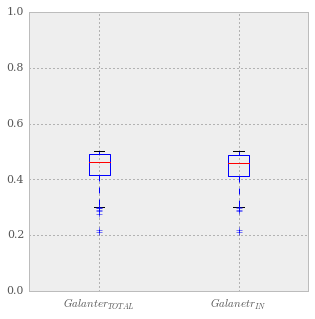

In [137]:
galanter_heter = galanter.join(df_1000genomes, rsuffix='_').heterozygosity
missing_heter = missing.join(df_1000genomes, rsuffix='_').heterozygosity

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.boxplot([galanter_heter, missing_heter])
ax.set_xticklabels(['$Galanter_{TOTAL}$', '$Galanetr_{IN}$'])
ax.set_ylim([0, 1])
plt.show()